# Simple Convolutional Neural Net for Image Recognition
## Introduction
In this short notebook we develope a small neural network which uses fully connected and convolutional layers to classify handwritten numbers from the MNIST database.


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.nn.functional as F 

First we want to download the dataset we train and later test on. This is done via the DataLoader function from torch. We load the data in individual batches that we will then use for the different training epochs.

In [3]:
# number of samples in each batch to load
batch_size = 20

# conversion function used in data loading
transform = transforms.ToTensor()

# training and test datasets:
data_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)
data_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)

# set up data loaders
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size)


7.9%

100.0%


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw


100.0%


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw




47.7%

100.0%


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw


100.0%


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw


Now that the download of our data is complete, we want to make ourselfs familiar with how the structure of the images we want to classify. For this we will plot the first picture of the first batch.

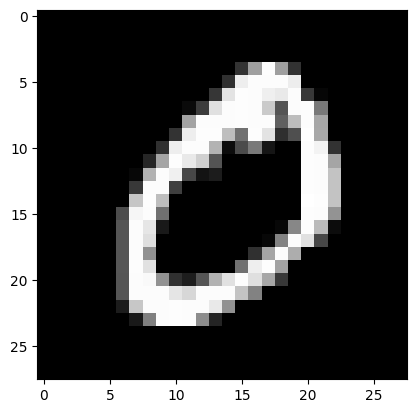

In [19]:
%matplotlib inline
# get a batch from the training loader
it = iter(train_loader)
images, lab = next(it)
images = images.numpy() #convert images to numpy datatypes

# pick first image and plot it
img = np.squeeze(images[1])
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')


As we see the data consists of a 2d array of pixels carrying different values, which may be interpreted as the brightness values of the corresponding pixels.

## The Neural Net
Our aim is to build a neural network with the ability to classify data of the form of the image above as a number from the set [0, 1, ... , 9]. It will receive the brightness values of the input image and then perform a 2d convolution with different kernels on it. The result will then be flattend and fed to a number of fully connected layers, with the last leading to ten outputs, representing the numbers 0 to 9. 


By adjusting the weights inside the kernels and fully connected layers to minimize the the total loss on the training set we hope to improve the network step by step.


But first, let's set up the network:

In [11]:
# define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # define architecture
        self.conv1 = nn.Conv2d(1, 8, (5, 5))
        self.fc1 = nn.Linear(24*24*8, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # add hidden relu layer
        x = F.relu(self.conv1(x))
        # flatten image
        x = x.view(-1, 24*24*8) # from three axes to single axis
        x = F.relu(self.fc1(x))
        return x
    


model = Net()

# define loss function
loss_fn = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.2)



For this example we chose the CrossEntropy loss function and stochastic gradient decend with momentum of 0.2 and a learning rate of 0.005.


Now let's train the model:


In [12]:
# define training epochs
n_epochs = 20
# set up model for training
model.train()

#training loop
for epoch in range(n_epochs):
    loss = 0.0
    for data, target in train_loader:
        # clear gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs into the net
        prediction = model(data)
        # calc loss
        current_loss = loss_fn(prediction, target)
        # backwards pass: compute gradient of loss in respect to model params
        current_loss.backward()
        # update parameters of model
        optimizer.step()
        # update total loss
        loss += current_loss.item()*data.size(0)
    
    # print training statistics
    # calc average epoch loss
    loss = loss/len(train_loader.sampler)
    print(f'Loss of Ep. {epoch +1 }: {loss:.6f}')


Loss of Ep. 1: 0.430993
Loss of Ep. 2: 0.274003
Loss of Ep. 3: 0.205922
Loss of Ep. 4: 0.153951
Loss of Ep. 5: 0.122378
Loss of Ep. 6: 0.103175
Loss of Ep. 7: 0.090494
Loss of Ep. 8: 0.081446
Loss of Ep. 9: 0.074597
Loss of Ep. 10: 0.069186
Loss of Ep. 11: 0.064757
Loss of Ep. 12: 0.061035
Loss of Ep. 13: 0.057843
Loss of Ep. 14: 0.055059
Loss of Ep. 15: 0.052595
Loss of Ep. 16: 0.050391
Loss of Ep. 17: 0.048396
Loss of Ep. 18: 0.046576
Loss of Ep. 19: 0.044901
Loss of Ep. 20: 0.043359


We can see that the loss on the training set slowly trends down. This means for each concurrent training episode we get smaller and smaller deviations from the labels of the training data.

In the next step we want to test the network on a dataset not yet seen by the network and evaluate its performance. For this we loaded the test dataset in the beginning.

In [14]:
# set up monitor lists for test:
test_loss = 0.0
correct_lst = list(0.0 for i in range(10))
total_lst = list(0.0 for i in range(10))

# set model in evaluation mode:
model.eval()

for data, target in test_loader:
    # forward pass: calc predictions
    prediction = model(data)
    # calc loss
    current_loss = loss_fn(prediction, target)
    # update test_loss
    test_loss += current_loss.item()*data.size(0)
    # get maximum prediction from probabilities
    _, pred = torch.max(prediction, 1)
    # compare to label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calc test accuracy
    for i in range(len(target)):
        label = target.data[i]
        correct_lst[label] += correct[i].item()
        total_lst[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print(f'Test loss: {test_loss:.6f}\n')

for i in range(10):
    if total_lst[i] > 0:
        print(f'Test accuracy for {str(i)}: {100*correct_lst[i]/total_lst[i]:4f}%')

print(f'\nOverall test accuracy: {100.0*np.sum(correct_lst)/np.sum(total_lst):4f}%')

Test loss: 0.057317

Test accuracy for 0: 99.387755%
Test accuracy for 1: 99.383260%
Test accuracy for 2: 97.771318%
Test accuracy for 3: 98.415842%
Test accuracy for 4: 99.083503%
Test accuracy for 5: 98.991031%
Test accuracy for 6: 96.868476%
Test accuracy for 7: 97.470817%
Test accuracy for 8: 97.330595%
Test accuracy for 9: 96.233895%

Overall test accuracy: 98.100000%
